In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin
np.random.seed(42)

In [22]:
data_path = "C:/Users/code/assignment_1"
df = pd.read_csv(f"{data_path}/data.csv", names=["x1", "x2", "x3", "y"], header=None)

### 1(a)Обучите линейную регрессию. Предскажите значения для x=1,2,3

In [23]:
X = np.array(df['x1']).reshape((-1, 1))
y = np.array(df['y'])
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
r_sq = model.score(X, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

coefficient of determination: 0.7415277828704888
intercept: 5.927948918101425
slope: [-2.03833663]


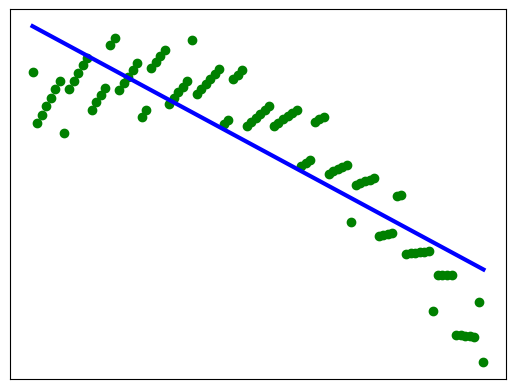

In [24]:
plt.scatter(X, y, color="green")
plt.plot(X, y_pred, color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

### 1(b)Используя кросс-валидацию и среднеквадратичную функцию потерь, оцените точность и способность к генерализации у модели

In [25]:
scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

-5.76 accuracy with a standard deviation of 4.74


### 1(c)Обучите полиномиальную регрессию, для кросс-валидации постройте график bias, variance в зависимости от степени полинома. Какая степень оптимальна? 

In [26]:
degree = 2  
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X)
model_poly = LinearRegression()
model_poly.fit(X_poly,  y)
y_poly = model_poly.predict(X_poly)

In [27]:
print(f"coefficient of determination of linear model: {model.score(X, y)}")
print(f"coefficient of determination of polynomial model: {model_poly.score(X_poly, y)}")

coefficient of determination of linear model: 0.7415277828704888
coefficient of determination of polynomial model: 0.9378306171354444


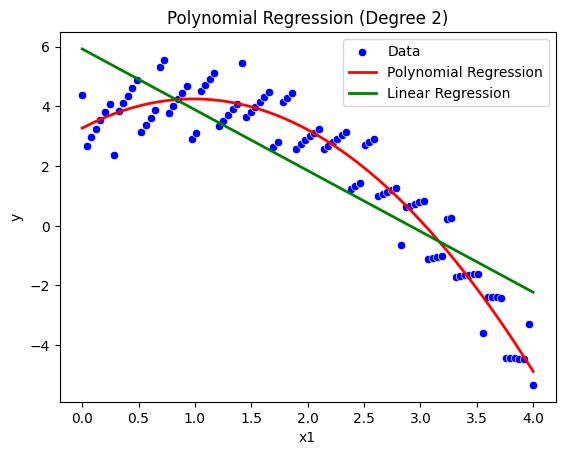

In [28]:
sns.scatterplot(df, x=df['x1'], y=df['y'], label='Data', color='blue')
sns.lineplot(x=df["x1"], y=y_poly, label='Polynomial Regression', color='red', linewidth=2)
sns.lineplot(x=df["x1"], y=y_pred, label='Linear Regression', color='green', linewidth=2)
plt.xlabel('x1')
plt.ylabel('y')
plt.legend()
plt.title(f'Polynomial Regression (Degree {degree})')
plt.show()

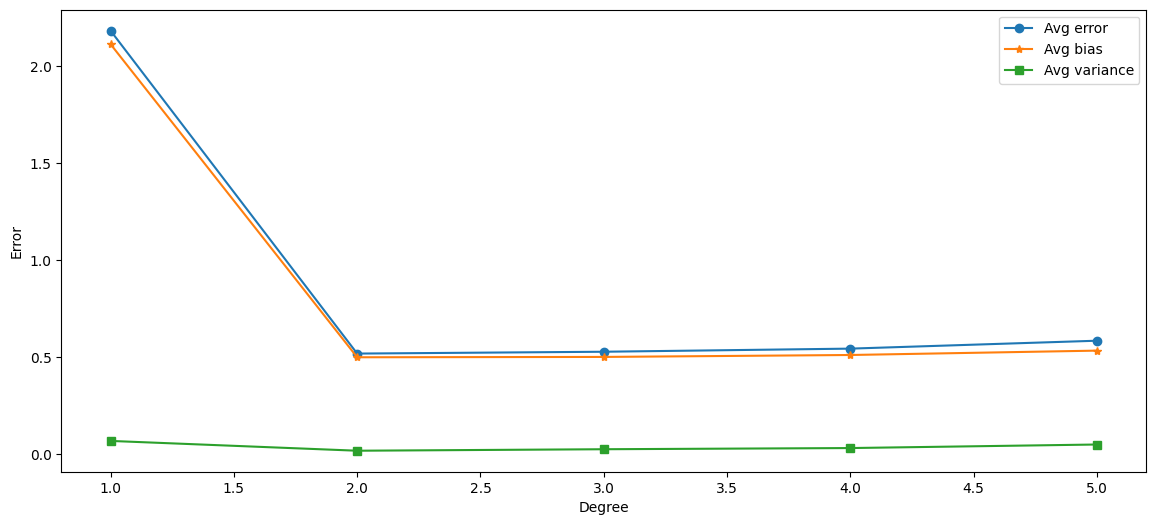

Optimal degree: 2
coefficient of determination of polynomial model: 0.9378306171354444


In [29]:
kf = KFold(shuffle=True)

def plot_bias_variance_error_with_cv(X, y):
    degrees = np.linspace(1, 5, 5, dtype='int')
    errors = []
    biases = []
    variances = []

    min_degree = 0 
    min_error = 100000

    for degree in degrees:
        poly_features = PolynomialFeatures(degree=degree)
        X_poly = poly_features.fit_transform(X)

        errors_ = []
        biases_ = []
        variances_ = []

        for train_index, test_index in kf.split(X_poly):
            X_train = X_poly[train_index] 
            X_test = X_poly[test_index]
            y_train = y[train_index] 
            y_test = y[test_index]

            error, bias, var = bias_variance_decomp(
                model, X_train, y_train, X_test, y_test, loss='mse'
            ) 
            
            errors_.append(error)
            biases_.append(bias)
            variances_.append(var)
        
        if np.mean(errors_) < min_error:
            min_error = np.mean(errors_)
            min_degree = degree

        errors.append(np.mean(errors_))
        biases.append(np.mean(biases_))
        variances.append(np.mean(variances_))

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(degrees, errors, label='Avg error', marker='o')
    ax.plot(degrees, biases, label='Avg bias', marker='*')
    ax.plot(degrees, variances, label='Avg variance', marker='s')
    ax.set_xlabel('Degree')
    ax.set_ylabel('Error')
    ax.legend()
    plt.show()
    
    print(f'Optimal degree: {min_degree}')
    poly_features = PolynomialFeatures(degree=min_degree)
    X_poly = poly_features.fit_transform(X)
    model_poly = LinearRegression().fit(X_poly, y)
    print(f"coefficient of determination of polynomial model: {model_poly.score(X_poly, y)}")

plot_bias_variance_error_with_cv(X, y)

### 1(d)Проведите подбор степени полинома с помощью любого из k-fold на 70% данных. Совпадают ли результаты? Оцените точность модели на оставшихся 30%. 

In [30]:
def find_optimal_degree(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    degrees = np.linspace(1, 5, 5, dtype='int')
    kf = KFold()

    min_degree = 0 
    min_error = 100000

    for degree in degrees:
        poly_features = PolynomialFeatures(degree=degree)
        X_train_poly = poly_features.fit_transform(X_train)
        
        errors_ = []

        for train_index, test_index in kf.split(X_train_poly):
            X_train_fold = X_train_poly[train_index] 
            X_val_fold = X_train_poly[test_index]
            y_train_fold = y_train[train_index]
            y_val_fold = y_train[test_index]

            model = LinearRegression()
            error, bias, var = bias_variance_decomp(
                model, X_train_fold, y_train_fold, X_val_fold, y_val_fold, loss='mse'
            ) 
            
            errors_.append(error)
        
        if np.mean(errors_) < min_error:
            min_error = np.mean(errors_)
            min_degree = degree

    print(f'Optimal degree: {min_degree}')

    poly_features = PolynomialFeatures(degree=min_degree)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)
    model_poly = LinearRegression().fit(X_train_poly, y_train)
    
    print(f"coefficient of determination of polynomial model: {model_poly.score(X_test_poly, y_test)}")

find_optimal_degree(X, y)

Optimal degree: 2
coefficient of determination of polynomial model: 0.9205950497624253


### 2

In [31]:
X = np.array(df[['x1', 'x2', 'x3']])
y = np.array(df['y'])
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
r_sq = model.score(X, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

coefficient of determination: 0.8062194616695001
intercept: 5.314167172512459
slope: [-2.00371927  0.53256334 -0.26560187]


In [32]:
scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

-5.55 accuracy with a standard deviation of 4.96


In [33]:
degree = 2
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X)
model_poly = LinearRegression().fit(X_poly,  y)

print(f"coefficient of determination of linear model: {model.score(X, y)}")
print(f"coefficient of determination of polynomial model: {model_poly.score(X_poly, y)}")

coefficient of determination of linear model: 0.8062194616695001
coefficient of determination of polynomial model: 1.0


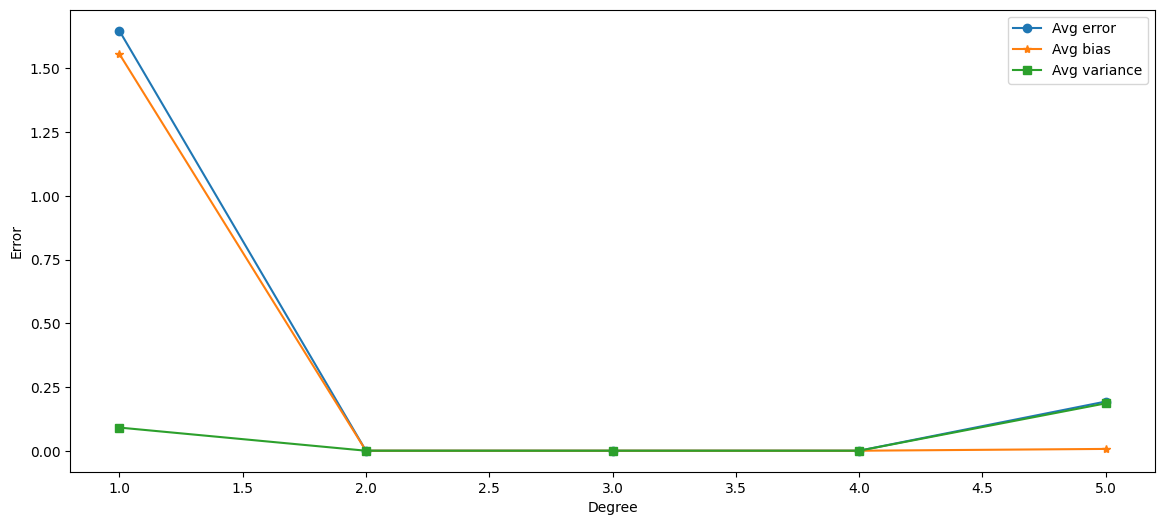

Optimal degree: 2
coefficient of determination of polynomial model: 1.0


In [34]:
plot_bias_variance_error_with_cv(X, y)

In [35]:
find_optimal_degree(X, y)

Optimal degree: 2
coefficient of determination of polynomial model: 1.0


### 3

In [36]:
class GaussianFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, N):
        self.N = N
    
    def _gauss_basis(self, x, y, sigma):
        return np.exp(-((x - y) ** 2) / (2 * sigma ** 2))
    
    def transform(self, X, y=None):
        self.centers_ = np.linspace(-1, 1, self.N)
        self.sigma_ = self.centers_[1] - self.centers_[0]
        X_gaussian = self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.sigma_)
        return X_gaussian.reshape(X.shape[0], -1)

In [37]:
X = np.array(df[['x1', 'x2', 'x3']])
y = np.array(df['y'])
gf = GaussianFeatures(2)
X_gaussian = gf.transform(X)
model = LinearRegression().fit(X_gaussian, y)
y_pred = model.predict(X_gaussian)
r_sq = model.score(X_gaussian, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

coefficient of determination: 0.9864176925155898
intercept: -7.663742773198544
slope: [-0.93248764 13.06695758 -1.69580407 -0.70950359  0.8573411   0.66941521]


In [38]:
scores = cross_val_score(model, X_gaussian, y, scoring='neg_mean_squared_error')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

-0.86 accuracy with a standard deviation of 0.82


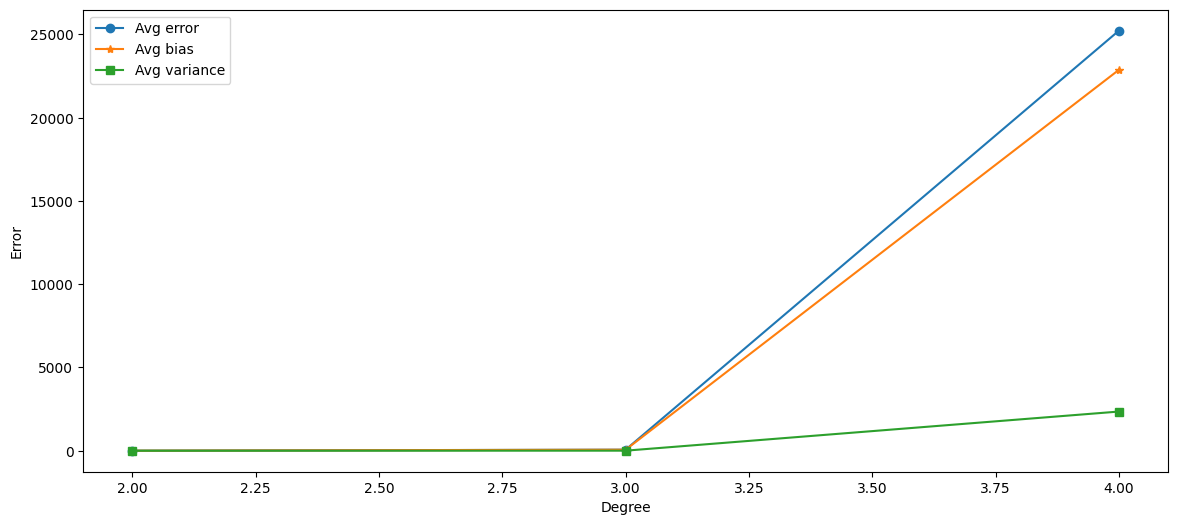

Optimal degree: 2
coefficient of determination of polynomial model: 0.9864176925155898


In [39]:
def plot_bias_variance_error_with_cv(X, y):
    degrees = np.linspace(2, 4, 3, dtype='int')
    errors = []
    biases = []
    variances = []
    kf = KFold()

    min_degree = 0 
    min_error = 100000

    for degree in degrees:
        gf = GaussianFeatures(degree)
        X_gaussian = gf.transform(X)    

        errors_ = []
        biases_ = []
        variances_ = []

        for train_index, test_index in kf.split(X_gaussian):
            X_train = X_gaussian[train_index] 
            X_test = X_gaussian[test_index]
            y_train = y[train_index] 
            y_test = y[test_index]

            error, bias, var = bias_variance_decomp(
                model, X_train, y_train, X_test, y_test, loss='mse'
            ) 
            
            errors_.append(error)
            biases_.append(bias)
            variances_.append(var)
        
        if np.mean(errors_) < min_error:
            min_error = np.mean(errors_)
            min_degree = degree

        errors.append(np.mean(errors_))
        biases.append(np.mean(biases_))
        variances.append(np.mean(variances_))

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(degrees, errors, label='Avg error', marker='o')
    ax.plot(degrees, biases, label='Avg bias', marker='*')
    ax.plot(degrees, variances, label='Avg variance', marker='s')
    ax.set_xlabel('Degree')
    ax.set_ylabel('Error')
    ax.legend()
    plt.show()
    
    print(f'Optimal degree: {min_degree}')
    gf = GaussianFeatures(min_degree)
    X_gaussian = gf.transform(X)
    model_gaussian = LinearRegression().fit(X_gaussian, y)
    print(f"coefficient of determination of polynomial model: {model_gaussian.score(X_gaussian, y)}")

plot_bias_variance_error_with_cv(X, y)

In [40]:
def find_optimal_degree(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    degrees = np.linspace(2, 4, 3, dtype='int')
    kf = KFold()

    min_degree = 0 
    min_error = 100000

    for degree in degrees:
        gf = GaussianFeatures(degree)
        X_train_gaussian = gf.transform(X_train)
        
        errors_ = []

        for train_index, test_index in kf.split(X_train_gaussian):
            X_train_fold = X_train_gaussian[train_index] 
            X_val_fold = X_train_gaussian[test_index]
            y_train_fold = y_train[train_index]
            y_val_fold = y_train[test_index]

            model = LinearRegression()
            error, bias, var = bias_variance_decomp(
                model, X_train_fold, y_train_fold, X_val_fold, y_val_fold, loss='mse'
            ) 
            
            errors_.append(error)
        
        if np.mean(errors_) < min_error:
            min_error = np.mean(errors_)
            min_degree = degree

    print(f'Optimal degree: {min_degree}')

    gf = GaussianFeatures(min_degree)
    X_train_gaussian = gf.transform(X_train)
    X_test_gaussian = gf.transform(X_test)
    model_poly = LinearRegression().fit(X_train_gaussian, y_train)
    
    print(f"coefficient of determination of polynomial model: {model_poly.score(X_test_gaussian, y_test)}")

find_optimal_degree(X, y)

Optimal degree: 2
coefficient of determination of polynomial model: 0.9856499734151913
